# Comparing fluxes with other products




In [1]:
import numpy as np
import xarray as xr
import rioxarray as rxr
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from odc.geo.geobox import zoom_out
from odc.geo.xr import assign_crs
from odc.algo import xr_reproject

import sys
sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from collect_prediction_data import allNaN_arg

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize

import warnings
warnings.filterwarnings("ignore")

## Analysis Parameters

In [2]:
var = 'NEE' #ER
var_fc = 'NEE' #TER
var_cable = 'nbp' #nbp
suffix='20221212'
trim=False
trim_date = '2003','2015'

results_name = var+'_2003_2021_5km_LGBM_'+suffix+'.nc'
# upper = 'NEE_2003_2021_5km_LGBM_quantiles.nc'

## Open various datasets

In [3]:
ds = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+results_name)
ds.attrs['nodata'] = np.nan

# ds_upper = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+upper)
# ds_upper.attrs['nodata'] = np.nan

# ds_lower = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+lower)
# ds_lower.attrs['nodata'] = np.nan

In [4]:
# mask = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/results/prediction_data/data_5km.nc')
# mask = mask[['FPAR']].to_array().isnull().all('variable')
# mask = mask.isel(time=1)

# ds = ds.where(~mask)
# ds_upper = ds_upper.where(~mask)

### Fluxcom

In [5]:
ds_fc = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/FLUXCOM/'+var_fc+'_rs.nc'), crs='epsg:4326').sel(time=slice('2003', '2015'))
# ds_fc = ds_fc.rename({'lat':'latitude', 'lon':'longitude'})
ds_fc.attrs['nodata'] = np.nan
ds_fc['latitude'] = ds_fc.latitude.astype('float32')
ds_fc['longitude'] = ds_fc.longitude.astype('float32')

ds_fc_met = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/FLUXCOM/'+var_fc+'_rs_meteo_era5.nc').sel(time=slice('2003', '2018')), crs='epsg:4326')
ds_fc_met = ds_fc_met.rename({'lat':'latitude', 'lon':'longitude'})
ds_fc_met.attrs['nodata'] = np.nan
ds_fc_met['latitude'] = ds_fc_met.latitude.astype('float32')
ds_fc_met['longitude'] = ds_fc_met.longitude.astype('float32')


In [6]:
ds_fc['time'] = ds.sel(time=slice('2003', '2015')).time
ds_fc_met['time'] = ds.sel(time=slice('2003', '2018')).time

### CABLE

<!-- '/g/data/os22/chad_tmp/NEE_modelling/data/CABLE/CABLE_ER_10km_monthly_2000_2019.nc' -->

In [7]:
cable = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/CABLE/CABLE-BIOS/CABLE_BIOS_'+var_cable+'_25km_monthly_2003_2019.nc')
cable_pop = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/CABLE/CABLE-POP_v10/CABLE-POP_'+var_cable+'_100km_monthly_2003_2020.nc')
cable_pop = cable_pop[var_cable]
# cable_nee = cable_nee.sel(time=slice('2003', '2015'))

### Fire emissions GFASv12

In [8]:
fire = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/FireEmissions_10km_monthly_2003_2021.nc')
fire = fire.sum(['x', 'y'])
fire = fire*12

### Obs GPP

In [9]:
if var == 'GPP':
    modis_gpp = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/MODIS_GPP_1km_monthly_2002_2021.nc')
    modis_gpp.attrs['nodata'] = np.nan

    gosif_gpp = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/5km/GOSIF_GPP_5km_monthly_2002_2021.nc')
    gosif_gpp.attrs['nodata'] = np.nan

### Villalobos et al 

Needed to fix the dataset before it could be opened. Used the R script in data/villalobos/

In [10]:
fn = '/g/data/os22/chad_tmp/NEE_modelling/data/villalobos/post.tif'
post = rxr.open_rasterio(fn).rename({'band':'month'})
post['month']=ds.sel(time=slice('2015', '2019')).time.values
post = post.rename({'month':'time'})
#post = xr_reproject(post, geobox=post.odc.geobox.to_crs('epsg:3577').compat, resampling='nearest')
# post = assign_crs(post, crs='epsg:3577')
post.attrs['nodata'] = np.nan
post.attrs['units'] = 'PgC/year'

fn = '/g/data/os22/chad_tmp/NEE_modelling/data/villalobos/land.tif'
cbl = rxr.open_rasterio(fn).rename({'band':'month'})
cbl['month']=ds.sel(time=slice('2015', '2019')).time.values
cbl = cbl.rename({'month':'time'})
#cable = xr_reproject(cable, geobox=cable.odc.geobox.to_crs('epsg:3577').compat, resampling='nearest')
# post = assign_crs(post, crs='epsg:3577')
cbl.attrs['nodata'] = np.nan
cbl.attrs['units'] = 'PgC/year'

fn = '/g/data/os22/chad_tmp/NEE_modelling/data/villalobos/fossil.tif'
ff = rxr.open_rasterio(fn).rename({'band':'month'})
ff['month']=ds.sel(time=slice('2015', '2019')).time.values
ff = ff.rename({'month':'time'})
#ff = xr_reproject(ff, geobox=ff.odc.geobox.to_crs('epsg:3577').compat, resampling='nearest')
# post = assign_crs(post, crs='epsg:3577')
ff.attrs['nodata'] = np.nan
ff.attrs['units'] = 'PgC/year'

#subtract fossile fuels from inversion
post = post - ff

# create a mask for this janky dataset
mask_inv = cbl.where(cbl==0).isel(time=1)
mask_inv = mask_inv.astype(bool)

post = post.where(mask_inv)

## Reproject to Albers Equal Area

In [11]:
# grid = zoom_out(ds.odc.geobox, 20)
# grid = grid.to_crs('EPSG:3577')
# grid

In [12]:
ds = xr_reproject(ds, geobox=ds.odc.geobox.to_crs('EPSG:3577').compat, resampling='bilinear')
# ds_upper = xr_reproject(ds_upper, geobox=ds.odc.geobox.to_crs('EPSG:3577').compat, resampling='bilinear')

In [13]:
ds_fc = xr_reproject(ds_fc, geobox=ds_fc.odc.geobox.to_crs('EPSG:3577').compat, resampling='bilinear')
ds_fc = ds_fc[var_fc] #.where(~mask.astype(bool))
ds_fc = ds_fc*30 #/day to /month

ds_fc_met = xr_reproject(ds_fc_met, geobox=ds_fc_met.odc.geobox.to_crs('EPSG:3577').compat, resampling='bilinear')
ds_fc_met = ds_fc_met[var_fc] #.where(~mask.astype(bool))
ds_fc_met = ds_fc_met*30 #/day to /month

In [14]:
cable = assign_crs(cable, crs='epsg:4326')
cable = xr_reproject(cable, geobox=cable.odc.geobox.to_crs('EPSG:3577').compat, resampling='bilinear') #['nbp']

cable_pop = assign_crs(cable_pop, crs='epsg:4326')
cable_pop = xr_reproject(cable_pop, geobox=cable_pop.odc.geobox.to_crs('EPSG:3577').compat, resampling='bilinear') #['nbp']

In [15]:
if var == 'GPP':
    # grid = zoom_out(ds.odc.geobox, 5)
    # grid = grid.to_crs('EPSG:3577')
    modis_gpp = xr_reproject(modis_gpp, geobox=ds.odc.geobox.compat, resampling='average')
    gosif_gpp = xr_reproject(gosif_gpp, geobox=gosif_gpp.odc.geobox.to_crs('EPSG:3577').compat, resampling='bilinear')

## Convert to total C in (petagrams) rather than gC/m2


In [16]:
ds = ds * ds.geobox.resolution[1]**2 * 1e-15 *12
# ds_upper = ds_upper * ds_upper.geobox.resolution[1]**2 * 1e-15 *12

ds_fc = ds_fc * ds_fc.geobox.resolution[1]**2 * 1e-15 * 12
ds_fc_met = ds_fc_met * ds_fc_met.geobox.resolution[1]**2 * 1e-15 * 12

cable = cable * cable.geobox.resolution[1]**2 * 1e-15 *12
cable_pop = cable_pop * cable_pop.geobox.resolution[1]**2 * 1e-15 *12

if var == 'GPP':
    modis_gpp = modis_gpp * modis_gpp.geobox.resolution[1]**2 * 1e-12
    modis_gpp = modis_gpp*12
    gosif_gpp = gosif_gpp * gosif_gpp.geobox.resolution[1]**2 * 1e-15
    gosif_gpp = gosif_gpp*12

## Export harmonized dataset

In [17]:
# merged = xr.merge([
#     ds_fc.rename('Fluxcom_RS_GPP'),
#     ds_fc_met.rename('Fluxcom_RS-meteo_GPP'),#,.sel(time=slice('2003', '2015')),
#     ds.rename('ThisStudy_GPP'),#.sel(time=slice('2003', '2015')),
#     cable_gpp.rename('Cable_GPP'),#.sel(time=slice('2003', '2015')),
#     modis_gpp.rename('MODIS_GPP'),#.sel(time=slice('2003', '2015')),
#     gosif_gpp.rename('GOSIF_GPP'),#.sel(time=slice('2003', '2015'))
# ])

# # merged = xr.merge([
# #     ds_fc_met.rename('Fluxcom_RS-Meteo_NEE'),
# #     ds_fc.rename('Fluxcom_RS_NEE'),#.sel(time=slice('2003', '2015')),
# #     ds.rename('ThisStudy_NEE'),#.sel(time=slice('2003', '2015')),
# #     cable_nee.rename('Cable_NEE')#.sel(time=slice('2003', '2015')),
# # ])

# merged.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/data/harmonized_gpp.nc')

## Plot time-series

In [18]:
if trim:
    ds = ds.sel(time=slice(trim_date[0], trim_date[1]))
    # ds_upper = ds_upper.sel(time=slice(trim_date[0], trim_date[1]))
    ds_fc = ds_fc.sel(time=slice(trim_date[0], trim_date[1]))
    ds_fc_met = ds_fc_met.sel(time=slice(trim_date[0], trim_date[1]))
    cable = cable.sel(time=slice(trim_date[0], trim_date[1]))
    cable_pop = cable_pop.sel(time=slice(trim_date[0], trim_date[1]))
    
    if var=='GPP':
        modis_gpp = modis_gpp.sel(time=slice(trim_date[0], trim_date[1]))
        gosif_gpp = gosif_gpp.sel(time=slice(trim_date[0], trim_date[1]))

In [19]:
ds_1d = ds.sum(['x', 'y'])
# ds_1d_upper = ds_upper.sum(['x', 'y'])

ds_fc_1d = ds_fc.sum(['x', 'y'])
ds_fc_met_1d = ds_fc_met.sum(['x', 'y'])

post_1d = post.sum(['x', 'y'])
cable_1d = cable.sum(['x', 'y'])
cable_pop_1d = cable_pop.sum(['x', 'y'])

if var=='GPP':
    gosif_gpp_1d = gosif_gpp.sum(['x', 'y'])
    modis_gpp_1d = modis_gpp.sum(['x', 'y'])

### Plot time-series w/o rolling mean

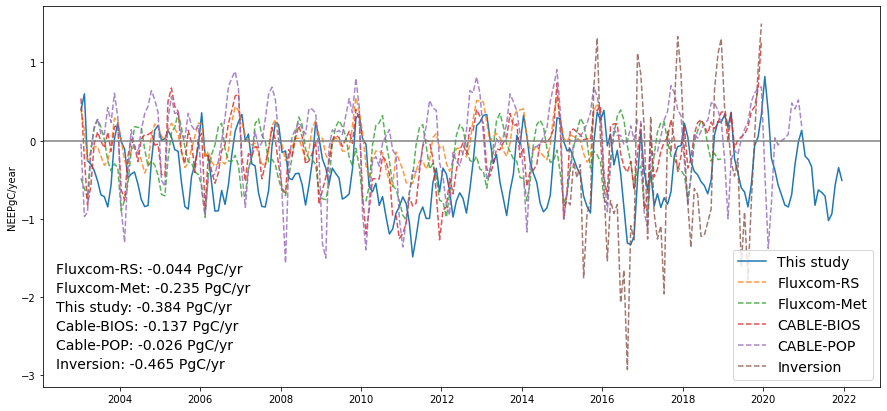

In [20]:
fig, ax = plt.subplots(1,1, figsize=(15,7))
ax.plot(ds_1d.time.values, ds_1d,  label='This study')
# ax.fill_between(ds_1d.time, ds_1d_upper.sel(quantile=0.25).rolling(time=3, min_periods=1).mean(),
#                 ds_1d_upper.sel(quantile=0.75).rolling(time=3, min_periods=1).mean(), alpha=0.2)

ax.plot(ds_fc_1d.time.values, ds_fc_1d, linestyle='--', label='Fluxcom-RS', alpha=0.8)
ax.plot(ds_fc_met_1d.time.values, ds_fc_met_1d, linestyle='--', label='Fluxcom-Met', alpha=0.8)
ax.plot(cable_1d.time.values, cable_1d, linestyle='--', label='CABLE-BIOS', alpha=0.8)
ax.plot(cable_pop_1d.time.values, cable_pop_1d, linestyle='--', label='CABLE-POP', alpha=0.8)

if var=='NEE':
    ax.plot(post_1d.time.values, post_1d, linestyle='--', label='Inversion', alpha=0.8)
    plt.axhline(0, c='grey')

if var == 'GPP':
    ax.plot(modis_gpp_1d.time.values, modis_gpp_1d, linestyle='--', label='MODIS', alpha=0.75)
    ax.plot(gosif_gpp_1d.time.values, gosif_gpp_1d, linestyle='--', label='GOSIF', alpha=0.75)

fontsize=14
ax.set_ylabel(var+'PgC/year')

if var=='NEE':
    ax.text(.015, .30, f'Fluxcom-RS: {ds_fc_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .25, f'Fluxcom-Met: {ds_fc_met_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .20, f'This study: {ds_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .15, f'Cable-BIOS: {cable_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .10, f'Cable-POP: {cable_pop_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes,fontsize=fontsize)
    ax.text(.015, .05, f'Inversion: {post_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.legend(loc='lower right', fontsize=fontsize);

if var == 'GPP':
    ax.text(.015, .95, f'Fluxcom-RS: {ds_fc_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .90, f'Fluxcom-Met: {ds_fc_met_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .85, f'This study: {ds_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .80, f'GOSIF: {gosif_gpp_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .75, f'MODIS: {modis_gpp_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .70, f'Cable-BIOS: {cable_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .65, f'Cable-POP: {cable_pop_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.legend(loc='upper right', fontsize=fontsize)

if var == 'ER':
    ax.text(.015, .95, f'Fluxcom-RS: {ds_fc_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .90, f'Fluxcom-Met: {ds_fc_met_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .85, f'This study: {ds_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .80, f'Cable-BIOS: {cable_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .75, f'Cable-POP: {cable_pop_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.legend(loc='upper right', fontsize=fontsize)



### Plot timeseries with rolling mean

In [21]:
roll_len=12

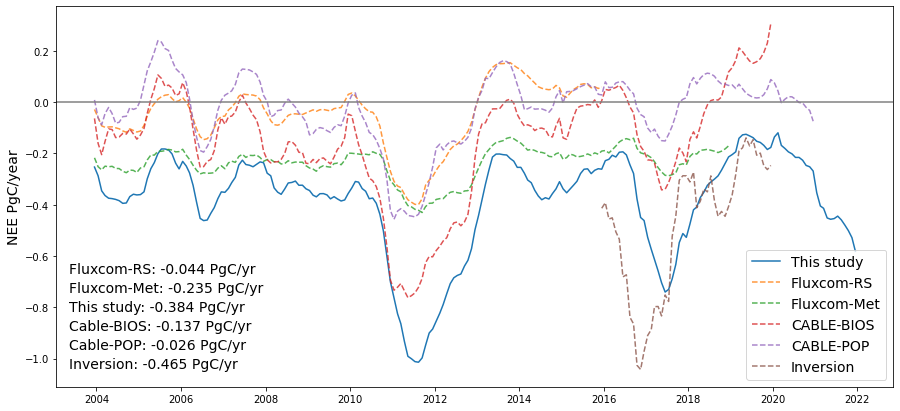

In [22]:
fig, ax = plt.subplots(1,1, figsize=(15,7))
ax.plot(ds_1d.time.values, ds_1d.rolling(time=roll_len, min_periods=roll_len).mean(),  label='This study')
# ax.fill_between(ds_1d.time, ds_1d_upper.sel(quantile=0.25).rolling(time=3, min_periods=1).mean(),
#                 ds_1d_upper.sel(quantile=0.75).rolling(time=3, min_periods=1).mean(), alpha=0.2)

ax.plot(ds_fc_1d.time.values, ds_fc_1d.rolling(time=roll_len, min_periods=roll_len).mean(), linestyle='--', label='Fluxcom-RS', alpha=0.8)
ax.plot(ds_fc_met_1d.time.values, ds_fc_met_1d.rolling(time=roll_len, min_periods=roll_len).mean(), linestyle='--', label='Fluxcom-Met', alpha=0.8)
ax.plot(cable_1d.time.values, cable_1d.rolling(time=roll_len, min_periods=roll_len).mean(), linestyle='--', label='CABLE-BIOS', alpha=0.8)
ax.plot(cable_pop_1d.time.values, cable_pop_1d.rolling(time=roll_len, min_periods=roll_len).mean(), linestyle='--', label='CABLE-POP', alpha=0.8)

if var=='NEE':
    ax.plot(post_1d.time.values, post_1d.rolling(time=roll_len, min_periods=roll_len).mean(), linestyle='--', label='Inversion', alpha=0.8)
    plt.axhline(0, c='grey')

if var == 'GPP':
    ax.plot(modis_gpp_1d.time.values, modis_gpp_1d.rolling(time=roll_len, min_periods=roll_len).mean(), linestyle='--', label='MODIS', alpha=0.75)
    ax.plot(gosif_gpp_1d.time.values, gosif_gpp_1d.rolling(time=roll_len, min_periods=roll_len).mean(), linestyle='--', label='GOSIF', alpha=0.75)

fontsize=14
ax.set_ylabel(var+' PgC/year', fontsize=fontsize);

if var=='NEE':
    ax.text(.015, .30, f'Fluxcom-RS: {ds_fc_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .25, f'Fluxcom-Met: {ds_fc_met_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .20, f'This study: {ds_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .15, f'Cable-BIOS: {cable_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .10, f'Cable-POP: {cable_pop_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes,fontsize=fontsize)
    ax.text(.015, .05, f'Inversion: {post_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.legend(loc='lower right', fontsize=fontsize);

if var == 'GPP':
    ax.text(.015, .95, f'Fluxcom-RS: {ds_fc_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .90, f'Fluxcom-Met: {ds_fc_met_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .85, f'This study: {ds_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .80, f'GOSIF: {gosif_gpp_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .75, f'MODIS: {modis_gpp_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .70, f'Cable-BIOS: {cable_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .65, f'Cable-POP: {cable_pop_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.legend(loc='upper right', fontsize=fontsize);

if var == 'ER':
    ax.text(.015, .95, f'Fluxcom-RS: {ds_fc_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .90, f'Fluxcom-Met: {ds_fc_met_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .85, f'This study: {ds_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .80, f'Cable-BIOS: {cable_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.text(.015, .75, f'Cable-POP: {cable_pop_1d.mean().values:.3f} PgC/yr',
            transform=ax.transAxes, fontsize=fontsize)
    ax.legend(loc='upper right', fontsize=fontsize);



### Time-series plots per bioclimatic regions 

In [23]:
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')

In [24]:
# Dictionary to save results 
results = {}
for index, row in gdf.iterrows():
    print(row['region_name'])
    datasets = {}
    
    ds_mask = xr_rasterize(gdf.iloc[[index]], ds)
    ds_fc_mask = xr_rasterize(gdf.iloc[[index]], ds_fc)
    ds_fc_met_mask = xr_rasterize(gdf.iloc[[index]], ds_fc_met)
    cable_mask = xr_rasterize(gdf.iloc[[index]], cable)
    cable_pop_mask = xr_rasterize(gdf.iloc[[index]], cable_pop)
    #post_mask = xr_rasterize(gdf.iloc[[index]], post)
    
    dss = ds.where(ds_mask)
    dss_fc = ds_fc.where(ds_fc_mask)
    dss_fc_met = ds_fc_met.where(ds_fc_met_mask)
    dss_cable= cable.where(cable_mask)
    dss_cable_pop = cable_pop.where(cable_pop_mask)
    #dss_post = post.where(post_mask)
    
    if var=='GPP':
        modis_gpp_mask = xr_rasterize(gdf.iloc[[index]], modis_gpp)
        gosif_gpp_mask = xr_rasterize(gdf.iloc[[index]], gosif_gpp)
        dss_modis = modis_gpp.where(modis_gpp_mask)
        dss_gosif = gosif_gpp.where(gosif_gpp_mask)
        
        datasets.update({
                    'This Study':dss,
                    'Fluxcom-RS':dss_fc,
                    'Fluxcom-Met':dss_fc_met,
                    'CABLE-BIOS':dss_cable,
                    'CABLE-POP':dss_cable_pop,
                    'MODIS-GPP':dss_modis,
                    'GOSIF-GPP':dss_gosif,
                    }
                   )
    else:
        datasets.update({
                        'This Study':dss,
                        'Fluxcom-RS':dss_fc,
                        'Fluxcom-Met':dss_fc_met,
                        'CABLE-BIOS':dss_cable,
                        'CABLE-POP':dss_cable_pop,
                        #'Inversion':dss_post
                        }
                       )
    
    # Append results to a dictionary using the attribute
    # column as an key
    results.update({row['region_name']: datasets})

Tropics
Savanna
Warm Temperate
Cool Temperate
Mediterranean
Desert


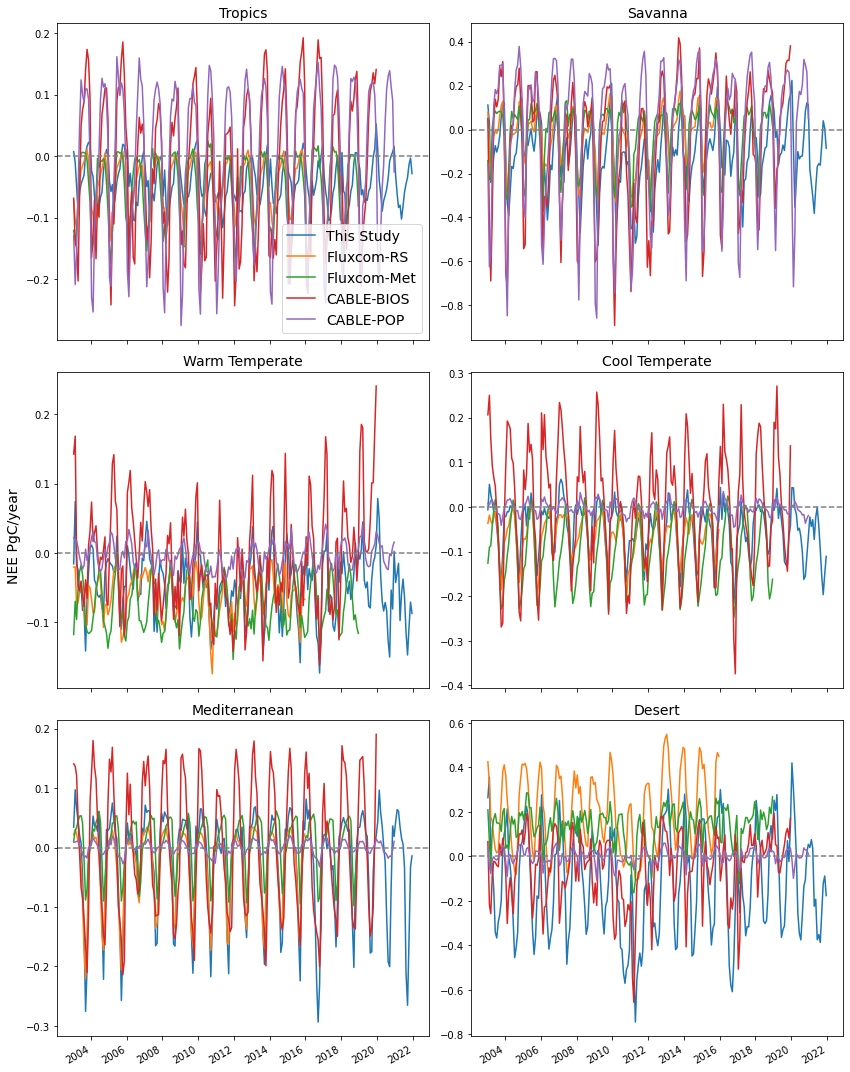

In [25]:
fig, axs = plt.subplots(3,2, figsize=(12,15), sharex=True)

for ax, k in zip(axs.ravel(), results.keys()):
    for source, da in results[k].items():
        #print(' ', source)
        _1D = da.sum(['x','y'])
        if source=='This Study':
            _1D.plot(ax=ax, label=source)
        else:
            _1D.plot(ax=ax, label=source)
        # ax.text(.015, .95, f'Mean: {_1D.mean().values:.3f}, std: {_1D.std().values:.3f} PgC/yr',
        #     transform=ax.transAxes, fontdict={'fontsize': 14})
    if var=='NEE':
        ax.axhline(0, c='grey', linestyle='--')
    
    ax.set_title(k, fontdict={'fontsize': 14})
    ax.set_ylabel('')
    ax.set_xlabel('')

axs[0,0].legend(fontsize=14)
fig.supylabel(var+' PgC/year', fontsize=14)
plt.tight_layout()
plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/'+var+'_bioregion_comparisons.png')

## Convert to anomalies

### Climatology

In [26]:
import warnings
warnings.filterwarnings("ignore")

ds_clim_mean = ds.groupby('time.month').mean()
# ds_upper_clim_mean = ds_upper.groupby('time.month').mean()
# ds_lower_clim_mean = ds_lower.groupby('time.month').mean()

ds_fc_clim_mean = ds_fc.groupby('time.month').mean()
ds_fc_met_clim_mean = ds_fc_met.groupby('time.month').mean()
post_clim_mean = post.groupby('time.month').mean()
cable_clim_mean = cable.groupby('time.month').mean()
cable_pop_clim_mean = cable_pop.groupby('time.month').mean()

if var=='GPP':
    modis_gpp_clim_mean = modis_gpp.groupby('time.month').mean()
    gosif_gpp_clim_mean = gosif_gpp.groupby('time.month').mean()
    #gosif_gpp_clim_mean_annual = gosif_gpp.resample(time='1Y', label='left', loffset='6M').sum().mean('time')


### Anomalies

In [27]:
ds_anom = (ds.groupby('time.month') - ds_clim_mean)
# ds_upper_anom = (ds_upper.groupby('time.month') - ds_clim_mean) 
# ds_lower_anom = (ds_lower.groupby('time.month') - ds_clim_mean)
ds_fc_anom = (ds_fc.groupby('time.month') - ds_fc_clim_mean)
ds_fc_met_anom = (ds_fc_met.groupby('time.month') - ds_fc_met_clim_mean)
post_anom = (post.groupby('time.month') - post_clim_mean)
cable_anom = (cable.groupby('time.month') - cable_clim_mean)
cable_pop_anom = (cable_pop.groupby('time.month') - cable_pop_clim_mean)

if var=='GPP':
    modis_gpp_anom = (modis_gpp.groupby('time.month') - modis_gpp_clim_mean)
    gosif_gpp_anom = (gosif_gpp.groupby('time.month') - gosif_gpp_clim_mean)

    # modis_gpp_anom_annual = modis_gpp.resample(time='1Y', label='left', loffset='6M').sum() - modis_gpp_clim_mean_annual
    # gosif_gpp_anom_annual = gosif_gpp.resample(time='1Y', label='left', loffset='6M').sum() - gosif_gpp_clim_mean_annual

### Zonal summaries

In [28]:
ds_1D = ds_anom.sum(['x','y'])
# ds_upper_1D = ds_upper_anom.sum(['x','y'])
# ds_lower_1D = ds_lower_anom.sum(['x','y'])
ds_fc_1D = ds_fc_anom.sum(['x','y'])
ds_fc_met_1D = ds_fc_met_anom.sum(['x','y'])

post_1D = post_anom.sum(['x','y'])
cable_1D = cable_anom.sum(['x','y'])
cable_pop_1D = cable_pop_anom.sum(['x','y'])

if var=='GPP':
    modis_gpp_1D = modis_gpp_anom.sum(['x','y'])
    gosif_gpp_1D = gosif_gpp_anom.sum(['x','y'])

### Plot timeseries

In [29]:
roll_len=12

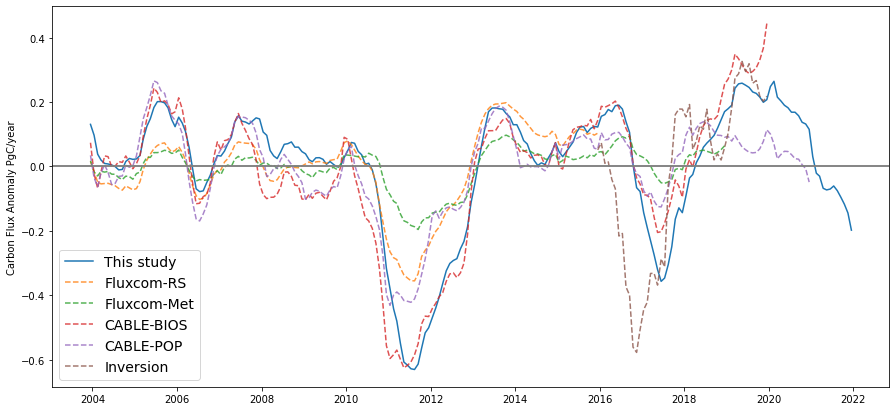

In [30]:
fig, ax = plt.subplots(1,1, figsize=(15,7))
ax.plot(ds_1D.time.values, ds_1D.rolling(time=roll_len, min_periods=roll_len).mean(),  label='This study')
ax.plot(ds_fc_1D.time.values, ds_fc_1D.rolling(time=roll_len, min_periods=roll_len).mean(), linestyle='--', label='Fluxcom-RS', alpha=0.8)
ax.plot(ds_fc_met_1D.time.values, ds_fc_met_1D.rolling(time=roll_len, min_periods=roll_len).mean(), linestyle='--', label='Fluxcom-Met', alpha=0.8)
ax.plot(cable_1D.time.values, cable_1D.rolling(time=roll_len, min_periods=roll_len).mean(), linestyle='--', label='CABLE-BIOS', alpha=0.8)
ax.plot(cable_pop_1D.time.values, cable_pop_1D.rolling(time=roll_len, min_periods=roll_len).mean(), linestyle='--', label='CABLE-POP', alpha=0.8)

if var=='NEE':
    ax.plot(post_1D.time.values, post_1D.rolling(time=roll_len, min_periods=roll_len).mean(), linestyle='--', label='Inversion', alpha=0.8)
    plt.axhline(0, c='grey')

if var == 'GPP':
    ax.plot(modis_gpp_1D.time.values, modis_gpp_1D.rolling(time=roll_len, min_periods=roll_len).mean(), linestyle='--', label='MODIS', alpha=0.75)
    ax.plot(gosif_gpp_1D.time.values, gosif_gpp_1D.rolling(time=roll_len, min_periods=roll_len).mean(), linestyle='--', label='GOSIF', alpha=0.75)

ax.set_ylabel('Carbon Flux Anomaly PgC/year')
ax.legend(loc='best', fontsize=14)
plt.axhline(0, c='grey');
# plt.title('Net Ecosystem Exchange Anomalies 12-month rolling mean');

## Climatology timeseries

### Aus wide 

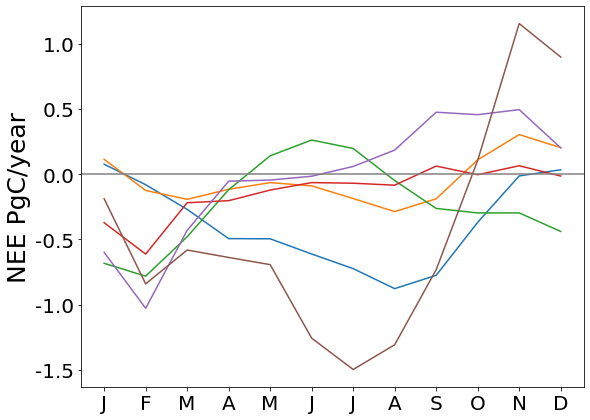

In [31]:
fig, ax = plt.subplots(1,1, figsize=(9,7))

y = ds_clim_mean.sum(['x','y']).values
x = ds_clim_mean.month.values

y_fc = ds_fc_clim_mean.sum(['x','y']).values
x_fc = ds_fc_clim_mean.month.values

y_fc_met = ds_fc_met_clim_mean.sum(['x','y']).values
x_fc_met = ds_fc_met_clim_mean.month.values

y_post = post_clim_mean.sum(['x','y']).values
x_post = post_clim_mean.month.values

y_cable = cable_clim_mean.sum(['x','y']).values
x_cable = cable_clim_mean.month.values

y_cable_pop = cable_pop_clim_mean.sum(['x','y']).values
x_cable_pop = cable_pop_clim_mean.month.values

if var =='GPP':
    y_modis_gpp = modis_gpp_clim_mean.sum(['x','y']).values
    x_modis_gpp = modis_gpp_clim_mean.month.values

    y_gosif_gpp = gosif_gpp_clim_mean.sum(['x','y']).values
    x_gosif_gpp = gosif_gpp_clim_mean.month.values


ax.plot(x, y,  label='This Study')
ax.plot(x_fc, y_fc, label='Fluxcom-RS')
ax.plot(x_fc_met, y_fc_met, label='Fluxcom-Met')
ax.plot(x_cable, y_cable, label='Cable-BIOS')
ax.plot(x_cable_pop, y_cable_pop, label='Cable-POP')

if var=='NEE':
    ax.plot(x_post, y_post, label='Inversion')

if var =='GPP':
    ax.plot(x_modis_gpp, y_modis_gpp, label='MODIS')
    ax.plot(x_gosif_gpp, y_gosif_gpp, label='GOSIF')


if var=='NEE':
    ax.axhline(0, c='grey')
# ax.legend(loc='best', fontsize=15)

ax.set_yticklabels(['{:3.1f}'.format(x) for x in ax.get_yticks()])
ax.set_xticks(range(1,13))
ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=15)    
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_ylabel(var+' PgC/year', fontsize=25);
plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/'+var+'_Aus_climatology_timeseries.png')

#### Save the legend as file

In [32]:
if var=='GPP':
    # get handles and labels for reuse
    label_params = ax.get_legend_handles_labels() 

    figl, axl = plt.subplots()
    axl.axis(False)
    axl.legend(*label_params, loc="best", fontsize=20, markerscale=2.0, ncol=2)
    figl.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/climatology_legend.png')

### Per bioregion

In [33]:
# Dictionary to save results 
results = {}
for index, row in gdf.iterrows():
    print(row['region_name'])
    datasets = {}
    
    ds_mask = xr_rasterize(gdf.iloc[[index]], ds)
    ds_fc_mask = xr_rasterize(gdf.iloc[[index]], ds_fc)
    ds_fc_met_mask = xr_rasterize(gdf.iloc[[index]], ds_fc_met)
    cable_mask = xr_rasterize(gdf.iloc[[index]], cable)
    cable_pop_mask = xr_rasterize(gdf.iloc[[index]], cable_pop)
    post_mask = xr_rasterize(gdf.iloc[[index]], post)
    
    dss = ds_clim_mean.where(ds_mask)
    dss_fc = ds_fc_clim_mean.where(ds_fc_mask)
    dss_fc_met = ds_fc_met_clim_mean.where(ds_fc_met_mask)
    dss_cable= cable_clim_mean.where(cable_mask)
    dss_cable_pop = cable_pop_clim_mean.where(cable_pop_mask)
    dss_post = post_clim_mean.where(post_mask)
    
    if var=='GPP':
        modis_gpp_mask = xr_rasterize(gdf.iloc[[index]], modis_gpp)
        gosif_gpp_mask = xr_rasterize(gdf.iloc[[index]], gosif_gpp)
        dss_modis = modis_gpp_clim_mean.where(modis_gpp_mask)
        dss_gosif = gosif_gpp_clim_mean.where(gosif_gpp_mask)
        
        datasets.update({
                    'This Study':dss,
                    'Fluxcom-RS':dss_fc,
                    'Fluxcom-Met':dss_fc_met,
                    'CABLE-BIOS':dss_cable,
                    'CABLE-POP':dss_cable_pop,
                    'MODIS-GPP':dss_modis,
                    'GOSIF-GPP':dss_gosif,
                    }
                   )
    if var=='NEE':
        datasets.update({
                        'This Study':dss,
                        'Fluxcom-RS':dss_fc,
                        'Fluxcom-Met':dss_fc_met,
                        'CABLE-BIOS':dss_cable,
                        'CABLE-POP':dss_cable_pop,
                        'Inversion':dss_post
                        }
                       )
    
    if var=='ER':
        datasets.update({
                        'This Study':dss,
                        'Fluxcom-RS':dss_fc,
                        'Fluxcom-Met':dss_fc_met,
                        'CABLE-BIOS':dss_cable,
                        'CABLE-POP':dss_cable_pop,
                        }
                       )
    
    # Append results to a dictionary using the attribute
    # column as an key
    results.update({row['region_name']: datasets})

Tropics
Savanna
Warm Temperate
Cool Temperate
Mediterranean
Desert


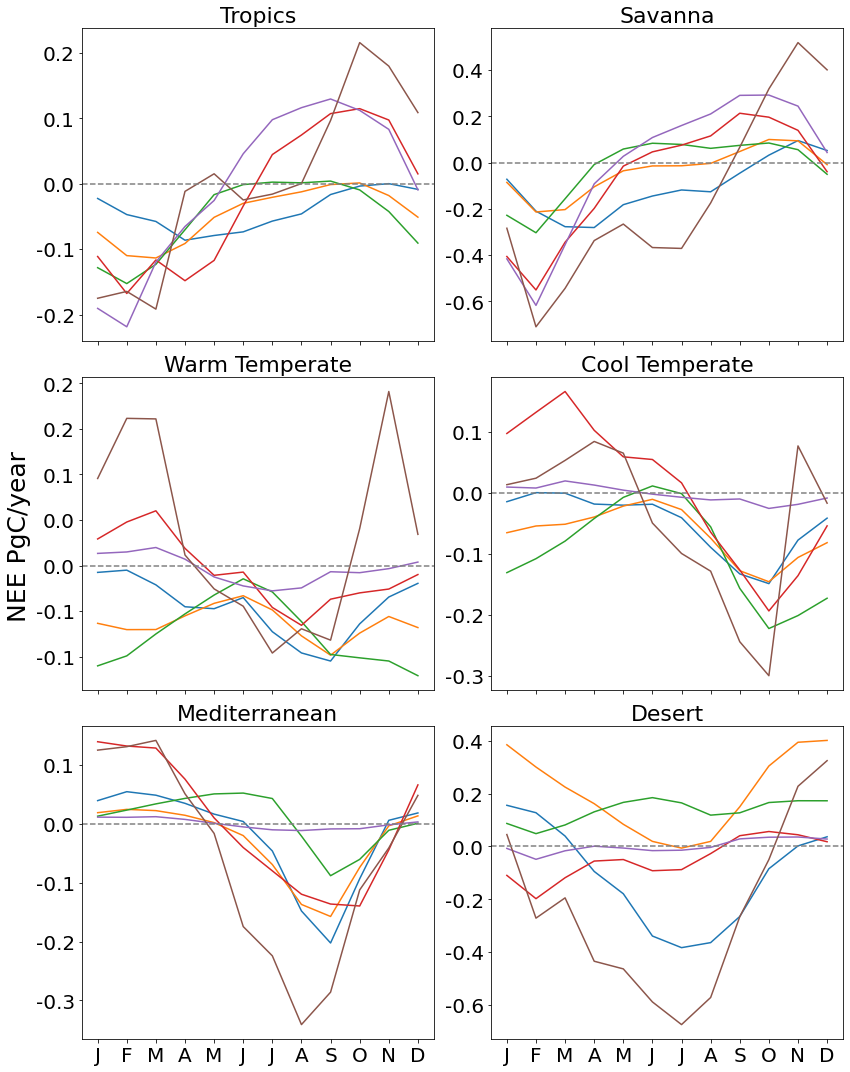

In [34]:
fig, axs = plt.subplots(3,2, figsize=(12,15), sharex=True)

for ax, k in zip(axs.ravel(), results.keys()):
    for source, da in results[k].items():
        #print(' ', source)
        _1D = da.sum(['x','y'])
        if source=='This Study':
            _1D.plot(ax=ax, label=source)
        else:
            _1D.plot(ax=ax, label=source)
    if var=='NEE':
        ax.axhline(0, c='grey', linestyle='--')
    
    ax.set_yticklabels(['{:3.1f}'.format(x) for x in ax.get_yticks()])
    ax.set_xticks(range(1,13))
    ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=17)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.set_title(k, fontdict={'fontsize': 22})
    ax.set_ylabel('')
    ax.set_xlabel('')

#axs[0,0].legend(fontsize=15)
fig.supylabel(var+' PgC/year', fontsize=25)
plt.tight_layout()
plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/'+var+'_bioregion_climatology_timeseries.png');

## Climatology per-pixel

In [35]:
if var == 'NEE':
    max_mean_month = allNaN_arg(ds_clim_mean, 'month', 'min')
    max_mean_month_fc = allNaN_arg(ds_fc_clim_mean, 'month', 'min')
    max_mean_month_fc_met = allNaN_arg(ds_fc_met_clim_mean, 'month', 'min')
    max_mean_month_post = allNaN_arg(post_clim_mean, 'month', 'min')
    max_mean_month_cable = allNaN_arg(cable_clim_mean, 'month', 'min')
    max_mean_month_cable_pop = allNaN_arg(cable_pop_clim_mean, 'month', 'min')

else:
    if var=='GPP':
        max_mean_month = allNaN_arg(ds_clim_mean, 'month', 'max')
        max_mean_month_fc = allNaN_arg(ds_fc_clim_mean, 'month', 'max')
        max_mean_month_fc_met = allNaN_arg(ds_fc_met_clim_mean, 'month', 'max')
        max_mean_month_modis = allNaN_arg(modis_gpp_clim_mean, 'month', 'max')
        max_mean_month_gosif = allNaN_arg(gosif_gpp_clim_mean, 'month', 'max')
        max_mean_month_cable = allNaN_arg(cable_clim_mean, 'month', 'max')
        max_mean_month_cable_pop = allNaN_arg(cable_pop_clim_mean, 'month', 'max')
    if var=='ER':
        max_mean_month = allNaN_arg(ds_clim_mean, 'month', 'max')
        max_mean_month_fc = allNaN_arg(ds_fc_clim_mean, 'month', 'max')
        max_mean_month_fc_met = allNaN_arg(ds_fc_met_clim_mean, 'month', 'max')
        max_mean_month_cable = allNaN_arg(cable_clim_mean, 'month', 'max')
        max_mean_month_cable_pop = allNaN_arg(cable_pop_clim_mean, 'month', 'max')

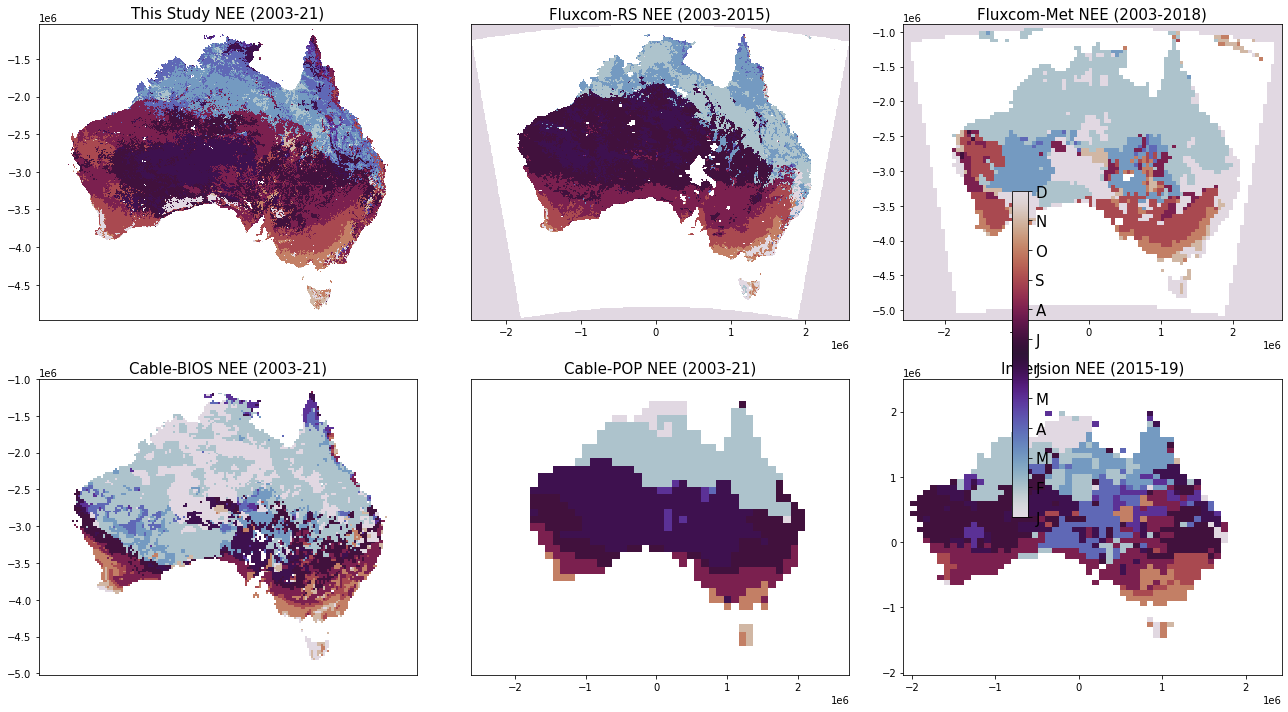

In [36]:
y_range = ' (2003-21)'
font=15
if var=='GPP':
    fig,ax = plt.subplots(2,4, figsize=(22,10))
    im = max_mean_month.plot.imshow(vmin=1, vmax=12, ax=ax[0,0], cmap='twilight', add_colorbar=False, add_labels=False)
    ax[0,0].set_title('This Study '+var+y_range, fontsize=font);

    im = max_mean_month_fc.plot.imshow(vmin=1, vmax=12, ax=ax[0,1], cmap='twilight', add_colorbar=False, add_labels=False)
    ax[0,1].set_title('Fluxcom-RS '+var+ ' (2003-2015)', fontsize=font);

    im = max_mean_month_fc_met.plot.imshow(vmin=1, vmax=12, ax=ax[0,2], cmap='twilight', add_colorbar=False, add_labels=False)
    ax[0,2].set_title('Fluxcom-Met '+var+' (2003-2018)', fontsize=font);

    im = max_mean_month_cable.plot.imshow(vmin=1, vmax=12, ax=ax[1,0], cmap='twilight', add_colorbar=False, add_labels=False)
    ax[1,0].set_title('Cable-BIOS '+var+y_range, fontsize=font);

    im = max_mean_month_cable_pop.plot.imshow(vmin=1, vmax=12, ax=ax[1,1], cmap='twilight', add_colorbar=False, add_labels=False)
    ax[1,1].set_title('Cable-POP '+var+y_range, fontsize=font);

    im = max_mean_month_post.isel(x=range(12, 68), y=range(12, 68)).plot.imshow(vmin=1, vmax=12, ax=ax[1,2], cmap='twilight', add_colorbar=False, add_labels=False)
    ax[1,2].set_title('Inversion '+var+' (2015-19)', fontsize=font);

    im = max_mean_month_modis.plot.imshow(vmin=1, vmax=12, ax=ax[1,1], cmap='twilight', add_colorbar=False)
    ax[1,1].set_title('MODIS '+var+y_range, fontsize=fonts);

    im = max_mean_month_gosif.plot.imshow(vmin=1, vmax=12, ax=ax[1,2], cmap='twilight', add_colorbar=False)
    ax[1,2].set_title('GOSIF '+var++y_range, fontsize=fonts);

if var=='NEE':
    fig,ax = plt.subplots(2,3, figsize=(18,10))
    im = max_mean_month.plot.imshow(vmin=1, vmax=12, ax=ax[0,0], cmap='twilight', add_colorbar=False, add_labels=False)
    ax[0,0].set_title('This Study '+var+y_range, fontsize=font);

    im = max_mean_month_fc.plot.imshow(vmin=1, vmax=12, ax=ax[0,1], cmap='twilight', add_colorbar=False, add_labels=False)
    ax[0,1].set_title('Fluxcom-RS '+var+ ' (2003-2015)', fontsize=font);

    im = max_mean_month_fc_met.plot.imshow(vmin=1, vmax=12, ax=ax[0,2], cmap='twilight', add_colorbar=False, add_labels=False)
    ax[0,2].set_title('Fluxcom-Met '+var+' (2003-2018)', fontsize=font);

    im = max_mean_month_cable.plot.imshow(vmin=1, vmax=12, ax=ax[1,0], cmap='twilight', add_colorbar=False, add_labels=False)
    ax[1,0].set_title('Cable-BIOS '+var+y_range, fontsize=font);

    im = max_mean_month_cable_pop.plot.imshow(vmin=1, vmax=12, ax=ax[1,1], cmap='twilight', add_colorbar=False, add_labels=False)
    ax[1,1].set_title('Cable-POP '+var+y_range, fontsize=font);

    im = max_mean_month_post.isel(x=range(12, 68), y=range(12, 68)).plot.imshow(vmin=1, vmax=12, ax=ax[1,2], cmap='twilight', add_colorbar=False, add_labels=False)
    ax[1,2].set_title('Inversion '+var+' (2015-19)', fontsize=font);

if var=='ER':
    fig,ax = plt.subplots(2,3, figsize=(22,10))
    im = max_mean_month.plot.imshow(vmin=1, vmax=12, ax=ax[0,0], cmap='twilight', add_colorbar=False, add_labels=False)
    ax[0,0].set_title('This Study '+var+y_range, fontsize=font);

    im = max_mean_month_fc.plot.imshow(vmin=1, vmax=12, ax=ax[0,1], cmap='twilight', add_colorbar=False, add_labels=False)
    ax[0,1].set_title('Fluxcom-RS '+var+ ' (2003-2015)', fontsize=font);

    im = max_mean_month_fc_met.plot.imshow(vmin=1, vmax=12, ax=ax[0,2], cmap='twilight', add_colorbar=False, add_labels=False)
    ax[0,2].set_title('Fluxcom-Met '+var+' (2003-2018)', fontsize=font);

    im = max_mean_month_cable.plot.imshow(vmin=1, vmax=12, ax=ax[1,0], cmap='twilight', add_colorbar=False, add_labels=False)
    ax[1,0].set_title('Cable-BIOS '+var+y_range, fontsize=font);

    im = max_mean_month_cable_pop.plot.imshow(vmin=1, vmax=12, ax=ax[1,1], cmap='twilight', add_colorbar=False, add_labels=False)
    ax[1,1].set_title('Cable-POP '+var+y_range, fontsize=font);
    

ax[0,0].set_xticks([])
ax[0,1].set_yticks([])
ax[1,0].set_xticks([])
ax[1,1].set_yticks([])
cbar = fig.colorbar(im, spacing='uniform', ax=ax.ravel().tolist(), orientation='vertical', shrink=0.6)
cbar.set_ticks([1,2,3,4,5,6,7,8,9,10,11,12])
cbar.set_ticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=font)
plt.tight_layout()
# plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/month_of_max_'+var+'.png')
